# Autobatching log-densities example

This notebook demonstrates a simple Bayesian inference example where autobatching makes user code easier to write, easier to read, and less likely to include bugs.

Inspired by a notebook by @davmre.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import itertools
import re
import sys
import time

from matplotlib.pyplot import *

import jax

from jax import lax
from jax import numpy as np
from jax import scipy
from jax import random

import numpy as onp
import scipy as oscipy

# Generate a fake binary classification dataset

In [0]:
onp.random.seed(10009)

num_features = 10
num_points = 100

true_beta = onp.random.randn(num_features).astype(np.float32)
all_x = onp.random.randn(num_points, num_features).astype(np.float32)
y = (onp.random.rand(num_points) < oscipy.special.expit(all_x.dot(true_beta))).astype(np.int32)

In [0]:
y

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

# Write the log-joint function for the model

We'll write a non-batched version, a manually batched version, and an autobatched version.

## Non-batched

In [0]:
def log_joint(beta):
    result = 0.
    # Note that no `axis` parameter is provided to `np.sum`.
    result = result + np.sum(scipy.stats.norm.logpdf(beta, loc=0., scale=1.))
    result = result + np.sum(-np.log(1 + np.exp(-(2*y-1) * np.dot(all_x, beta))))
    return result

In [0]:
log_joint(onp.random.randn(num_features))

/Users/mhoffman/mypython/lib/python2.7/site-packages/jax/lib/xla_bridge.py:146: UserWarning: No GPU found, falling back to CPU.
  warnings.warn('No GPU found, falling back to CPU.')


array(-213.23558, dtype=float32)

In [0]:
# This doesn't work, because we didn't write `log_prob()` to handle batching.
batch_size = 10
batched_test_beta = onp.random.randn(batch_size, num_features)

log_joint(onp.random.randn(batch_size, num_features))

ValueError: Incompatible shapes for broadcasting: ((100, 10), (1, 100))

## Manually batched

In [0]:
def batched_log_joint(beta):
    result = 0.
    # Here (and below) `sum` needs an `axis` parameter. At best, forgetting to set axis
    # or setting it incorrectly yields an error; at worst, it silently changes the
    # semantics of the model.
    result = result + np.sum(scipy.stats.norm.logpdf(beta, loc=0., scale=1.),
                           axis=-1)
    # Note the multiple transposes. Getting this right is not rocket science,
    # but it's also not totally mindless. (I didn't get it right on the first
    # try.)
    result = result + np.sum(-np.log(1 + np.exp(-(2*y-1) * np.dot(all_x, beta.T).T)),
                           axis=-1)
    return result

In [0]:
batch_size = 10
batched_test_beta = onp.random.randn(batch_size, num_features)

batched_log_joint(batched_test_beta)

array([-147.84033 , -207.02205 , -109.26075 , -243.8083  , -163.02911 ,
       -143.84848 , -160.28772 , -113.77169 , -126.605446, -190.81989 ],
      dtype=float32)

## Autobatched with vmap

It just works.

In [0]:
vmap_batched_log_joint = jax.vmap(log_joint)
vmap_batched_log_joint(batched_test_beta)

array([-147.84033 , -207.02205 , -109.26075 , -243.8083  , -163.02911 ,
       -143.84848 , -160.28772 , -113.77169 , -126.605446, -190.81989 ],
      dtype=float32)

# Self-contained variational inference example

A little code is copied from above.

## Set up the (batched) log-joint function

In [0]:
@jax.jit
def log_joint(beta):
    result = 0.
    # Note that no `axis` parameter is provided to `np.sum`.
    result = result + np.sum(scipy.stats.norm.logpdf(beta, loc=0., scale=10.))
    result = result + np.sum(-np.log(1 + np.exp(-(2*y-1) * np.dot(all_x, beta))))
    return result

batched_log_joint = jax.jit(jax.vmap(log_joint))

## Define the ELBO and its gradient

In [0]:
def elbo(beta_loc, beta_log_scale, epsilon):
    beta_sample = beta_loc + np.exp(beta_log_scale) * epsilon
    return np.mean(batched_log_joint(beta_sample), 0) + np.sum(beta_log_scale - 0.5 * onp.log(2*onp.pi))
elbo = jax.jit(elbo, static_argnums=(2, 3))
elbo_val_and_grad = jax.jit(jax.value_and_grad(elbo, argnums=(0, 1)))

## Optimize the ELBO using SGD

In [0]:
def normal_sample(key, shape):
    """Convenience function for quasi-stateful RNG."""
    new_key, sub_key = random.split(key)
    return new_key, random.normal(sub_key, shape)
normal_sample = jax.jit(normal_sample, static_argnums=(1,))

key = random.PRNGKey(10003)

beta_loc = np.zeros(num_features, np.float32)
beta_log_scale = np.zeros(num_features, np.float32)

step_size = 0.01
batch_size = 128
epsilon_shape = (batch_size, num_features)
for i in range(1000):
    key, epsilon = normal_sample(key, epsilon_shape)
    elbo_val, (beta_loc_grad, beta_log_scale_grad) = elbo_val_and_grad(
        beta_loc, beta_log_scale, epsilon)
    beta_loc += step_size * beta_loc_grad
    beta_log_scale += step_size * beta_log_scale_grad
    if i % 10 == 0:
        print('{}\t{}'.format(i, elbo_val))

0	-180.853881836
10	-113.060455322
20	-102.737258911
30	-99.7873535156
40	-98.9089889526
50	-98.297454834
60	-98.1863174438
70	-97.5797195435
80	-97.2860031128
90	-97.4699630737
100	-97.4771728516
110	-97.5806732178
120	-97.494354248
130	-97.5027313232
140	-96.8639526367
150	-97.4419784546
160	-97.0694046021
170	-96.8402862549
180	-97.2133789062
190	-97.5650253296
200	-97.2639770508
210	-97.1197967529
220	-97.395942688
230	-97.1683197021
240	-97.1184082031
250	-97.2434539795
260	-97.2978668213
270	-96.692855835
280	-96.9643859863
290	-97.3005523682
300	-96.6359176636
310	-97.0351867676
320	-97.529083252
330	-97.2881164551
340	-97.0732192993
350	-97.1561889648
360	-97.2588195801
370	-97.1951446533
380	-97.1309204102
390	-97.1172637939
400	-96.9387359619
410	-97.2667694092
420	-97.353225708
430	-97.2100753784
440	-97.2843475342
450	-97.1630859375
460	-97.2612457275
470	-97.2134399414
480	-97.2399749756
490	-97.1491317749
500	-97.2352828979
510	-96.9342041016
520	-97.212097168
530	-96.825

## Display the results

Coverage isn't quite as good as we might like, but it's not bad, and nobody said variational inference was exact.

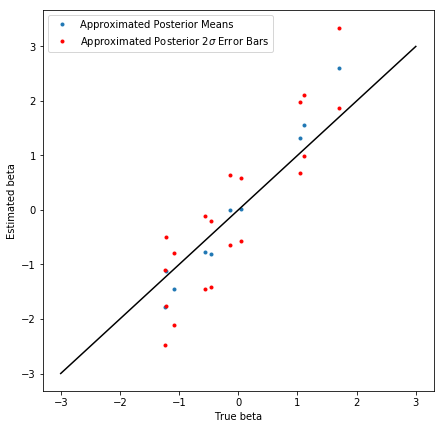

In [0]:
figure(figsize=(7, 7))
plot(true_beta, beta_loc, '.', label='Approximated Posterior Means')
plot(true_beta, beta_loc + 2*np.exp(beta_log_scale), 'r.', label='Approximated Posterior $2\sigma$ Error Bars')
plot(true_beta, beta_loc - 2*np.exp(beta_log_scale), 'r.')
plot_scale = 3
plot([-plot_scale, plot_scale], [-plot_scale, plot_scale], 'k')
xlabel('True beta')
ylabel('Estimated beta')
legend(loc='best')